In [ ]:
# Install necessary package for unsupervised learning
! pip install unsloth

In [ ]:
import os
from datasets import load_dataset

# Define the path for the training dataset (ensure no sensitive info in path). The dataset should contain two columns:
# - "mail": This is the input text to be used for training.
# - "Catégorie du ticket": This is the annotation, representing the target category for classification.
HOME_PATH = "/home/ubuntu/"
train_dataset_name = os.path.join(HOME_PATH, "train_set_filtred.csv")

# Load the dataset from CSV file
dataset = load_dataset("csv",data_files = train_dataset_name)

# Print dataset details: number of prompts and column names
print(f'Number of prompts: {len(dataset)}')
print(f'Column names are: {dataset.column_names}')

In [ ]:
# Import necessary components from unsloth for language llm
from unsloth import FastLanguageModel
import torch

# Load pre-trained language model with options for memory optimization (4-bit)
model, tokenizer = FastLanguageModel.from_pretrained(
    "unsloth/Qwen2.5-14B-Instruct-bnb-4bit",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.1.5: Fast Qwen2 patching. Transformers: 4.49.0.dev0.
   \\   /|    GPU: NVIDIA A10. Max memory: 21.975 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.6. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!




/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-20 15:34:44.077835: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-20 15:34:44.091037: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737387284.106257   10466 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737387284.110882   10466 cuda_blas.cc:1418] Unable to

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    lora_alpha=16,
    lora_dropout=0,
    target_modules=["q_proj", "k_proj", "v_proj", "up_proj", "down_proj", "o_proj", "gate_proj"],  # we train all language layers and MLP layers
    use_rslora=True,
    use_gradient_checkpointing="unsloth"
)

Unsloth 2025.1.5 patched 48 layers with 48 QKV layers, 48 O layers and 48 MLP layers.


In [ ]:
# Define prompt for ticket classification assistant
prompt = """
Tu es un assistant spécialisé dans la classification de tickets à partir de leur contenu textuel. Ton objectif est d’analyser la description fournie et de l’associer à l’une des catégories ci-dessous :
```
Demande de service/Backup #BCS/Autre - Autre
Demande de service/Backup #BCS/Demande de renseignement - Demande de renseignement
Demande de service/Backup #BCS/Restauration qualifiée - Restauration qualifiée
Demande de service/Backup #BCS/Stratégie de sauvegarde/Création - Création
Demande de service/Backup #BCS/Stratégie de sauvegarde/Modification - Modification
Demande de service/Backup #BCS/Stratégie de sauvegarde/Suppression - Suppression
Demande de service/Cyber Sécurité #CS2/Bastion/Création-Modification d'entrées - Création-Modification d'entrées
Incidents/Backup #BCS/Sauvegarde - Sauvegarde
Incidents/Supervision - Supervision
```
### Règles :
1. Réponds uniquement par la catégorie exacte, sans texte supplémentaire.
2. La catégorie associée doit être unique.
3. Si aucune catégorie ne correspond, la valeur de "categorisation" doit être "unknown".

### Exemple :
La description:
Bonjour¤ Merci de relancer les sauvegardes FULL¤ si ils ne sont pas repassées en automatique. Ghislain Envoyé de mon iPhone Début du message transféré
#### Sortie :
{{
  "categorisation": "Incidents/Backup #BCS/Sauvegarde - Sauvegarde"
}}

Analyse uniquement la description suivante :
{content}
"""

# Format for predicting the category for each sample
prediction_format = """
{{
  "categorisation": "{category}"
}}
"""

In [ ]:
# Helper function to convert data into a conversation format
def convert_to_conversation(sample):
    new_conversation = [
        { "role": "user",
          "content" : prompt.format(content = sample["mail"]),
        },
        { "role": "assistant",
          "content" : prediction_format.format(category = sample["Catégorie du ticket"])
        }
    ]
    return {"messages" : new_conversation}

In [ ]:
# Convert the dataset to a conversation format
converted_dataset = [convert_to_conversation(sample) for sample in dataset['train']]
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': '\nTu es un assistant spécialisé dans la classification de tickets à partir de leur contenu textuel. Ton objectif est d’analyser la description fournie et de l’associer à l’une des catégories ci-dessous\u202f:\n```\nDemande de service/Backup #BCS/Autre - Autre\nDemande de service/Backup #BCS/Demande de renseignement - Demande de renseignement\nDemande de service/Backup #BCS/Restauration qualifiée - Restauration qualifiée\nDemande de service/Backup #BCS/Stratégie de sauvegarde/Création - Création\nDemande de service/Backup #BCS/Stratégie de sauvegarde/Modification - Modification\nDemande de service/Backup #BCS/Stratégie de sauvegarde/Suppression - Suppression\nDemande de service/Cyber Sécurité #CS2/Bastion/Création-Modification d\'entrées - Création-Modification d\'entrées\nIncidents/Backup #BCS/Sauvegarde - Sauvegarde\nIncidents/Supervision - Supervision\n```\n### Règles :\n1. Réponds uniquement par la catégorie exacte, sans texte supplément

In [ ]:
# Function to format prompts for tokenization
def formatting_prompts_func(examples):
    try:
        convos = examples["dataset"]
        texts = [tokenizer.apply_chat_template(convo['messages'], tokenize = False, add_generation_prompt = False) for convo in convos]
        return { "text" : texts, }
    except:
        print('error')
        raise

In [ ]:
# Convert the dataset to a format suitable for processing
from datasets import Dataset
my_dataset = Dataset.from_dict({"dataset": converted_dataset})

In [ ]:
# Apply formatting to the dataset
dataset = my_dataset.map(formatting_prompts_func, batched = True,)
dataset[2]['text']

'<|im_start|>system\nYou are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>\n<|im_start|>user\n\nTu es un assistant spécialisé dans la classification de tickets à partir de leur contenu textuel. Ton objectif est d’analyser la description fournie et de l’associer à l’une des catégories ci-dessous\u202f:\n```\nDemande de service/Backup #BCS/Autre - Autre\nDemande de service/Backup #BCS/Demande de renseignement - Demande de renseignement\nDemande de service/Backup #BCS/Restauration qualifiée - Restauration qualifiée\nDemande de service/Backup #BCS/Stratégie de sauvegarde/Création - Création\nDemande de service/Backup #BCS/Stratégie de sauvegarde/Modification - Modification\nDemande de service/Backup #BCS/Stratégie de sauvegarde/Suppression - Suppression\nDemande de service/Cyber Sécurité #CS2/Bastion/Création-Modification d\'entrées - Création-Modification d\'entrées\nIncidents/Backup #BCS/Sauvegarde - Sauvegarde\nIncidents/Supervision - Supervision\n```\n### Règle

In [ ]:
# Preprocess function for batch tokenization
from functools import partial
def preprocess_batch(batch, tokenizer, max_length):
    """
    Tokenizes dataset batch

    :param batch: Dataset batch
    :param tokenizer: Model tokenizer
    :param max_length: Maximum number of tokens to emit from the tokenizer
    """

    return tokenizer(
        text=batch["text"],
        max_length = max_length,
        truncation = True,
    )


def preprocess_dataset(tokenizer, max_length: int, seed, my_dataset: str):
    """
    Tokenizes dataset for fine-tuning

    :param tokenizer (AutoTokenizer): Model tokenizer
    :param max_length (int): Maximum number of tokens to emit from the tokenizer
    :param seed: Random seed for reproducibility
    :param dataset (str): Instruction dataset
    """
    columns_names = my_dataset.column_names
    columns_names.append('text')

    # Apply preprocessing to each batch of the dataset & and remove initial columns and "text" fields
    _preprocessing_function = partial(preprocess_batch, max_length = max_length, tokenizer = tokenizer)

    my_dataset = my_dataset.map(
        _preprocessing_function,
        batched = True,
        remove_columns = columns_names,
    )

    # Filter out samples that have "input_ids" exceeding "max_length"
    my_dataset = my_dataset.filter(lambda sample: len(sample["input_ids"]) < max_length)

    # Shuffle dataset
    my_dataset = my_dataset.shuffle(seed = seed)

    return my_dataset

In [ ]:
max_length = 2048
seed = 33
preprocessed_dataset = preprocess_dataset(tokenizer, max_length, seed, dataset)

In [ ]:
preprocessed_dataset

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 3524
})

In [ ]:
import torch

# Define data collator for batching input during training
class TextDataCollator:
    def __init__(self, model, tokenizer, max_length=2048):
        self.model = model
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __call__(self, examples):
        # Pad or truncate input_ids and attention_mask
        input_ids = [ex["input_ids"][:self.max_length] for ex in examples]
        attention_mask = [ex["attention_mask"][:self.max_length] for ex in examples]

        # Pad sequences to max_length
        input_ids = torch.nn.utils.rnn.pad_sequence(
            [torch.tensor(ids) for ids in input_ids],
            batch_first=True,
            padding_value=0
        )

        attention_mask = torch.nn.utils.rnn.pad_sequence(
            [torch.tensor(mask) for mask in attention_mask],
            batch_first=True,
            padding_value=0
        )

        # Add labels (same as input_ids for language modeling)
        labels = input_ids.clone()

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

# Set up the training configuration and trainer

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator =  TextDataCollator(model, tokenizer),
    train_dataset = preprocessed_dataset,
    dataset_text_field = "text",
    max_seq_length = 2048,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        #max_steps = 30,
        num_train_epochs = 1,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 3,524 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 30
 "-____-"     Number of trainable parameters = 68,812,800



Step,Training Loss
1,2.197800
2,2.646600
3,2.502100
4,1.931900
5,1.673800
6,1.553800
7,1.323400
8,1.195500
9,0.911400
10,0.787000


<IPython.core.display.HTML object>

In [ ]:
# Push trained model and tokenizer to Hugging Face Hub (ensure tokens are replaced by placeholders)
model.push_to_hub("your_hf_hub", token="hf_XXXXXXXX")
tokenizer.push_to_hub("you_hf_hub", token="hf_XXXXXXXXXX")

In [ ]:
import pandas as pd
# Save training logs to a CSV file
pd.DataFrame(trainer.state.log_history).to_csv(os.path.join(HOME_PATH, "qwen_log.csv"))

In [ ]:
# Display training logs in DataFrame
df = pd.DataFrame(trainer.state.log_history)
df

,loss,grad_norm,learning_rate,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,2.1978,13.724114,0.000040,0.002270,1,NaN,NaN,NaN,NaN,NaN
1,2.6466,15.350007,0.000080,0.004540,2,NaN,NaN,NaN,NaN,NaN
2,2.5021,4.597202,0.000120,0.006810,3,NaN,NaN,NaN,NaN,NaN
3,1.9319,1.482393,0.000160,0.009081,4,NaN,NaN,NaN,NaN,NaN
4,1.6738,1.011267,0.000200,0.011351,5,NaN,NaN,NaN,NaN,NaN
5,1.5538,1.074024,0.000192,0.013621,6,NaN,NaN,NaN,NaN,NaN
6,1.3234,0.837895,0.000184,0.015891,7,NaN,NaN,NaN,NaN,NaN
7,1.1955,0.863191,0.000176,0.018161,8,NaN,NaN,NaN,NaN,NaN
8,0.9114,0.933489,0.000168,0.020431,9,NaN,NaN,NaN,NaN,NaN
9,0.7870,0.785147,0.000160,0.022701,10,NaN,NaN,NaN,NaN,NaN


      loss  grad_norm  learning_rate     epoch  step  train_runtime  \
0   2.1978  13.724114       0.000040  0.002270     1            NaN   
1   2.6466  15.350007       0.000080  0.004540     2            NaN   
2   2.5021   4.597202       0.000120  0.006810     3            NaN   
3   1.9319   1.482393       0.000160  0.009081     4            NaN   
4   1.6738   1.011267       0.000200  0.011351     5            NaN   
5   1.5538   1.074024       0.000192  0.013621     6            NaN   
6   1.3234   0.837895       0.000184  0.015891     7            NaN   
7   1.1955   0.863191       0.000176  0.018161     8            NaN   
8   0.9114   0.933489       0.000168  0.020431     9            NaN   
9   0.7870   0.785147       0.000160  0.022701    10            NaN   
10  0.8155   0.675480       0.000152  0.024972    11            NaN   
11  0.7825   0.800122       0.000144  0.027242    12            NaN   
12  0.6439   0.609302       0.000136  0.029512    13            NaN   
13  0.

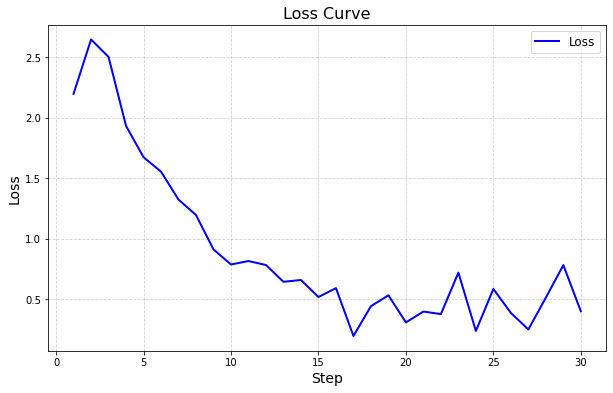

<Figure size 720x432 with 1 Axes>

In [ ]:
import matplotlib.pyplot as plt


# Plot the training loss curve
loss = df['loss']
step = df['step']

plt.figure(figsize=(10, 6))
plt.plot(step, loss, label='Loss', color='blue', linewidth=2)

plt.title("Loss Curve", fontsize=16)
plt.xlabel("Step", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.show()